# Description

This notebook is intended to test FEM capabilities using libigl bound to python.

# Load libraries

In [50]:
import igl
import scipy as sp
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import time
from IPython import display

shadingOptions = {
    "flat":True,
    "wireframe":True,
}

# Initial parameters

## Initial mesh

In [116]:
# Read mesh and retrieve shape
v, t = igl.read_msh("meshes/ball.msh")
print("===== Characteristics of the mesh =====")
print("Number of vertices: {}".format(v.shape[0]))
print("Number of tetrahedrons: {}".format(t.shape[0]))

# Rubber characteristics
rho     = 1.522 # [kg.m-3]
young   = 0.1e9 # [Pa]
poisson = 0.4   # [no unit]

# Visualize
mp.plot(v, t, shading=shadingOptions)

===== Characteristics of the mesh =====
Number of vertices: 198
Number of tetrahedrons: 636


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0020764…

## Boundary constraints

# Basis functions

## Definition

In [3]:
def inTriangle(X, Xtri):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtri : position of the triangle's vertices, row by row
    
    Output:
    - isInside : whether the point belongs to the triangle or not
    '''
    abg      = np.linalg.solve(Xtri.T, X)
    isInside = (abs(np.sum(abg) - 1) < 1e-9) and (0. <= abg <= 1.)
    return isInside

def inTet(X, Xtet):
    '''
    Input:
    - X    : position of the point for which we test belonging
    - Xtet : position of the tetrahedron's vertices, row by row
    
    Output:
    - isInside : whether the point is inside the tet or not
    '''
    abg      = np.linalg.solve(Xtet[:3, :] - Xtet[3, :], X - Xtet[3, :])
    isInside = (np.sum(abg) <= 1) and (0. <= abg <= 1.)
    return isInside

def basisEvalTri(v, f, X, v_id, f_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - f    : indices of the element's vertices (nE, 3)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - f_id : face id of the 
    
    Output:
    - val : value of the basis function at X
    '''
    # Permute indices so that the first row in Xtri (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed area
    nPerm   = np.argwhere(f[f_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%f.shape[1] for i in range(f.shape[1])]
    
    # Select with permutation
    Xtri    = v[f[f_id]][idxPerm, :]
    
    # Compute gradients
    dirOrt  = (Xtri[1, :] - Xtri[2, :]) / np.linalg.norm(Xtri[1, :] - Xtri[2, :])
    gradDir = (Xtri[0, :] - Xtri[1, :]) - dirOrt @ (Xtri[0, :] - Xtri[1, :]) * dirOrt
    grad    = gradDir / (gradDir @ (Xtri[0, :] - Xtri[1, :]))
    
    # Compute value:
    val = grad @ (X - Xtri[1, :])
    
    return val

def basisEvalTet(v, t, X, v_id, t_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - t    : indices of the element's vertices (nE, 4)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - t_id : face id of the tetrahedron
    
    Output:
    - val : value of the basis function at X
    '''
    # Permute indices so that the first row in Xtet (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed volume
    nPerm   = np.argwhere(t[t_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%t.shape[1] for i in range(t.shape[1])]
    
    # Select with permutation
    Xtet    = v[t[t_id]][idxPerm, :]
    
    # Compute gradients
    gradDir = np.cross(Xtet[2, :] - Xtet[1, :], Xtet[3, :] - Xtet[1, :])
    grad    = gradDir / (gradDir @ (Xtet[0, :] - Xtet[1, :]))
    
    # Compute value:
    val = grad @ (X - Xtet[1, :])
    
    return val

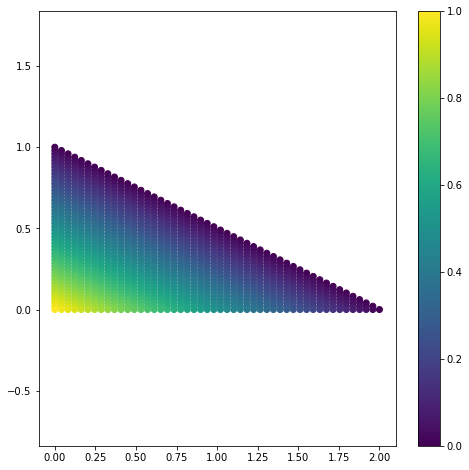

In [76]:
testV = np.array([[0., 0., 0.],
                  [0., 1., 0.],
                  [2., 0., 0.]])

testF = np.array([[0, 1, 2]])

# Barycentric coordinates
as_, bs_ = np.linspace(0, 1), np.linspace(0, 1)

abgs = []
for a in as_:
    for b in bs_:
        g = 1. - a - b
        if g >= 0:
            abgs.append([a, b, g])
                
ABGs = np.array(abgs)

# Points coordinates
pointsPlot = ABGs @ testV[testF[0]]

# Compute basis function value
vals = np.zeros(shape=pointsPlot.shape[0])
for i, point in enumerate(pointsPlot):
    vals[i] = basisEvalTri(testV, testF, point, 0, 0)

plt.figure(figsize=(8, 8))
sc = plt.scatter(pointsPlot[:, 0], pointsPlot[:, 1], c=vals)
plt.colorbar(sc)
plt.axis('equal')
plt.show()

## Gradients

In [5]:
def basisGradEvalTri(v, f, X, v_id, f_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - f    : indices of the element's vertices (nE, 3)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - f_id : face id of the 
    
    Output:
    - grad : value of the gradient of the basis function at X
    '''
    # Permute indices so that the first row in Xtri (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed area
    nPerm   = np.argwhere(f[f_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%f.shape[1] for i in range(f.shape[1])]
    
    # Select with permutation
    Xtri    = v[f[f_id]][idxPerm, :]
    
    # Compute gradients
    dirOrt  = (Xtri[1, :] - Xtri[2, :]) / np.linalg.norm(Xtri[1, :] - Xtri[2, :])
    gradDir = (Xtri[0, :] - Xtri[1, :]) - dirOrt @ (Xtri[0, :] - Xtri[1, :]) * dirOrt
    grad    = gradDir / (gradDir @ (Xtri[0, :] - Xtri[1, :]) + 1e-5)
    
    return grad

def basisGradEvalTet(v, t, X, v_id, t_id):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - t    : indices of the element's vertices (nE, 4)
    - X    : position of the point for which we test belonging
    - v_id : vertex id of the basis function
    - t_id : tet id
    
    Output:
    - grad : value of the gradient of the basis function at X
    '''
    # Permute indices so that the first row in Xtet (see bellow) is v_id
    # This is done so that the we preserve the sign of the signed volume
    nPerm   = np.argwhere(t[t_id] == v_id)[0, 0]
    idxPerm = [(i+nPerm)%t.shape[1] for i in range(t.shape[1])]
    
    # Select with permutation
    Xtet    = v[t[t_id]][idxPerm, :]
    
    # Compute gradients
    gradDir = np.cross(Xtet[2, :] - Xtet[1, :], Xtet[3, :] - Xtet[1, :])
    grad    = gradDir / (gradDir @ (Xtet[0, :] - Xtet[1, :]))
    
    return grad

# Explicit time integration

## Precomputation

In [19]:
def Precomputation(v, t):
    '''
    Input:
    - v    : position of the vertices of the mesh (nV, 3)
    - t    : indices of the element's vertices (nE, 4)
    
    Output:
    - vols    : np array of shape (nE,) containing the volume elements
    - invDisp : np array of shape (nE, 3, 3) containing the inverted undeformed displacement matrices
    '''
    
    nE      = t.shape[0]
    vols    = np.zeros(shape=(nE,))
    invDisp = np.zeros(shape=(nE, 3, 3))
    
    for i, tet in enumerate(t):
        Xtet = v[tet]
        disp = np.zeros(shape=(3, 3))
        disp[:, 0] = Xtet[0, :] - Xtet[3, :]
        disp[:, 1] = Xtet[1, :] - Xtet[3, :]
        disp[:, 2] = Xtet[2, :] - Xtet[3, :]
        
        vols[i] = abs(np.linalg.det(disp)) / 6
        invDisp[i, :, :] = np.linalg.inv(disp)
        
    return vols, invDisp

In [20]:
vols, invDisp = Precomputation(v, t)

## Elastic Forces

In [122]:
def ComputeElasticForces(vDef, t, vols, invDisp, young=0.1e9, poisson=0.4):
    '''
    Input:
    - vDef    : position of the vertices of the deformed mesh (nV, 3)
    - t       : indices of the element's vertices (nE, 4)
    - vols    : np array of shape (nE,) containing the volume elements
    - invDisp : np array of shape (nE, 3, 3) containing the inverted undeformed displacement matrices
    - young   : Young's modulus [Pa]
    - poisson : Poisson ratio [no unit]
    
    Output:
    - force : np array of shape (nV, 3) containing the force per vertex [N]
    '''
    
    lbda = young * poisson / ((1 + poisson) * (1 - 2 * poisson))
    mu   = young / (2 * (1 + poisson))
    
    nV = v.shape[0]
    forces = np.zeros(shape=(nV, 3))
    
    disp = np.zeros(shape=(3, 3))
    for i, tet in enumerate(t):
        Xtet = vDef[tet]
        disp[:, 0] = Xtet[0, :] - Xtet[3, :]
        disp[:, 1] = Xtet[1, :] - Xtet[3, :]
        disp[:, 2] = Xtet[2, :] - Xtet[3, :]
        
        # Jacobian of the deformation
        F = disp @ invDisp[i]
        
        # Linear elasticity
        strain = 0.5 * (F.T + F) - np.eye(3)
        
        # Piola-Kirchhoff stress tensor
        P = 2 * mu * strain + lbda * np.trace(strain) * np.eye(3)
        
        # Forces
        F = - vols[i] * P @ invDisp[i].T
        forces[tet[0], :] += F[:, 0]
        forces[tet[1], :] += F[:, 1]
        forces[tet[2], :] += F[:, 2]
        forces[tet[3], :] += - np.sum(F, axis=1)
        
    return forces

In [125]:
randPert = 0.02 * np.random.uniform(low=-1., high=1., size=v.shape)
forces = ComputeElasticForces(v + randPert, t, vols, invDisp, young=young, poisson=poisson)

p = mp.plot(v + randPert, t, shading=shadingOptions)
p.add_lines(v + randPert, v + randPert + 1e-7*forces)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.003608…

1

## Explicit time integration

In [98]:
def MassMatrix(v, t, vols=None, lumped=True):
    '''
    Input:
    - v      : position of the vertices of the mesh (nV, 3)
    - t      : indices of the element's vertices (nE, 4)
    - vols   : np array of shape (nE,) containing the volume elements
    - lumped : whether we want a diagonal matrix in the end
    
    Output:
    - massMatrix : np array of shape (nV, nV) containing the volume elements
    '''
    
    nV = v.shape[0]
    massMatrix = np.zeros(shape=(nV, nV))
    if vols is None:
        vols, _ = Precomputation(v, t)
    
    # Matrices we add have the same structure and can be reused
    submatrix = 1/24 * (np.ones(shape=(4, 4)) + 2*np.eye(4))
    for i, tet in enumerate(t):
        # Construct all pairs of indices
        idxColumn, idxRow = np.meshgrid(tet, tet)
        massMatrix[idxRow, idxColumn] += vols[i] * submatrix
        
    if lumped:
        massMatrix = np.diag(np.sum(massMatrix, axis=1))
        
    return massMatrix

In [130]:
help(p.save)

Help on method save in module meshplot.Viewer:

save(filename='') method of meshplot.Viewer.Viewer instance



In [136]:
# %%capture

randPert = 0.04 * np.random.uniform(low=-1., high=1., size=v.shape)
nSteps   = 10
dt       = 1e-6

vTmp    = v + randPert
velTmp  = np.zeros(shape=vTmp.shape)
totMass = rho * np.sum(vols)

for step in range(nSteps):
    display.clear_output(wait=True)
    forces  = ComputeElasticForces(vTmp, t, vols, invDisp, young=young, poisson=poisson)
    massTmp = np.diag(MassMatrix(vTmp, t, vols=None, lumped=True))
    velTmp += dt * np.diag(1 / (rho * massTmp)) @ forces # only works for diagonal matrices
    vTmp   += dt * velTmp
    p = mp.plot(vTmp, t, shading=shadingOptions)
#     p.save("output/explicitSphere/step{}".format(step))
    time.sleep(0.05)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.010566…

# Implicit time integration

## Mass matrix computation

In [114]:
mass = MassMatrix(v, t, vols=vols, lumped=True)
mass[:5, :5]

array([[0.00063649, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00215548, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.0015907 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00243047, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00156046]])

## Force differential